### Self-Supervised Single Image (Monocular) Depth Estimation 
###### Sanjay Gupta 
###### s347gupta@uwaterloo.ca 

#### Abstract

Goal: This project aims to learn the algorithmic weights pertaining to the Monocular Depth Estimation problem. Namely, by training a neural network on recitified stereo pairs -- note that only the left image is passed in as an input to the network -- the model is capable overcoming the limitations of fully supervised methods where data scarcity is a major bottleneck, by producing accurate disparity maps based on geometric principles (consider SfM, epipolar constraints, etc).

Well-Motivated Methodology: The methodology behind this project leverages the foundational work of Clement Godard et al. (2017), "Unsupervised Monocular Depth Estimation with Left-Right Consistency", which introduced an unsupervised approach to Monocular Depth Estimation by leveraging stereo pairs and a novel left-right consistency loss. This and a disparity smoothness loss (for ensuring locally smooth disparities) is used to improve upon the performance of just using the appearance reconstruction loss. Additionally, we follow the implementation in having the network produce disparity maps at different resolutions, capturing key contextual information that would otherwise be unavailable if only one map was generated towards the end.

Our model is trained and evaluated on the KITTI dataset, a benchmark dataset for autonomous driving that provides stereo images, LiDAR-based ground truth depth maps, and camera calibration information. Note that the utility functions file contains a script that downloads and extracts all raw synced/rectified image pairs directly from https://www.cvlibs.net/datasets/kitti/eval_depth_all.php.

To ensure consistent benchmarking, we adopt the widely used Eigen split, first proposed by Eigen et al (2014) in "Depth map prediction from a single image using a multi-scale deep network". This enables train-validation splits and evaluation protocols, ensuring comparability between pre-existing solutions. Together, these tools and frameworks form a well-motivated methodology for developing and evaluating Monocular Depth Estimation models.


#### Code Libraries

Note that an anaconda prompt was opened and the following commands were executed.
```console
conda create --name depth_estimation_env python=3.10 
conda activate depth_estimation_env 
conda install jupyter 
conda install pytorch torchvision torchaudio -c pytorch -c nvidia 
conda install tensorboard 
conda install numpy matplotlib
```

PyTorch/Torchvision:
- Core libraries for building and training neural networks and the dataloaders for processing large amounts of training data
- Compiled with CUDA to enable GPU acceleration for training/inference

NumPy: 
- Effienctly perform operations on large arrays/tensors of data
- Numerical constant/functions 

Matplotlib:
- Data visualization library to view network-output disparity maps inline (for the notebook)

Tensorboard:
- Live visualization of training metrics (loss) over each epoch


mylibs: contains two files, dwonload_kitti.py and utils.py

download_kitti.py: Script to download the synced/rectified stereo images from KITTI benchmark suite. Please note that setting DOWNLAOD=True below will download around 170 GB of image data. This can be reduced if png's are converted to jpeg's.

utils.py:
- As described in the paper by Godard, this file contains pytorch implementations that are utilized as intermediates throughout the network. 
- Defines wrapper functions to ensure consitency between network layers/proper spatial reductions between blocks
- Loss function is implemented in this file as MDELoss 
```console
credit to https://github.com/OniroAI/MonoDepth-PyTorch/blob/master/ for main implementation, removed un-needed functions/modified to better reflect this project/ coding style.
```

#### Setup
first lets verify that the notebook can recognize the imported libraries from conda and that the GPU is available.

In [1]:
import numpy as np
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available. CUDA is not supported.")
print("CUDA version:", torch.version.cuda)



PyTorch version: 2.5.1
CUDA available: True
Number of GPUs: 1
GPU 0: NVIDIA GeForce RTX 3080
CUDA version: 12.4


#### KITTI Dataset

In [2]:
import os
from typing import Any, Callable, List, Optional, Tuple

from PIL import Image

from torchvision.datasets.utils import download_url
from torchvision.datasets.vision import VisionDataset
from torchvision.transforms.functional import adjust_brightness, adjust_contrast, adjust_gamma, adjust_hue, adjust_saturation, hflip, vflip

import shutil
import zipfile

TRAIN = 0
VALIDATION = 1
TEST = 2

class MyKitti(VisionDataset):
    left_image_dir = "image_02"  # Left images
    right_image_dir = "image_03"  # Right images

    def __init__(
        self,
        root: str,
        transforms: Optional[Callable] = None,
        dataFile: str = None,
        codeEnum: int = 0,
        sanity_check: int = None
    ):
        super().__init__()
        self.images_left = []
        self.images_right = []
        self.root = root
        self.transforms = transforms
        self.codeEnum = codeEnum

        with open(dataFile, "r") as f:
            lines = f.readlines()
        lines = [line.strip() for line in lines]
        sorted_lines = sorted(lines)
        
        
        for i, line in enumerate(sorted_lines):
            if codeEnum < 2: # skip every other line
                if i % 2 == 0:
                    continue
            # tokenize line by spaces
            tokens = line.split(" ")
            drive = tokens[0].split("/")[1]
            frame = tokens[1]
            # reference = tokens[2] # l or r
            self.add_image(frame, drive, self.left_image_dir, self.images_left)
            self.add_image(frame, drive, self.right_image_dir, self.images_right)

        if sanity_check:
            self.images_left = [self.images_left[sanity_check]]
            self.images_right = [self.images_right[sanity_check]]

        print(f"Number of left images: {len(self.images_left)}")
        print(f"Number of right images: {len(self.images_right)}")

    def add_image(self, frame, drive, image_dir, image_list):
        image_list.append(os.path.join(self._raw_folder, image_dir, drive, frame.zfill(10) + ".png"))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Returns a pair of stereo images: left and right.
        MIGHT NEED TO UPDATE FOR TESTING DATA WHERE NO RIGHT IMAGE IS AVAILABLE
        """
        left_image = Image.open(self.images_left[index]).convert("RGB")
        right_image = Image.open(self.images_right[index]).convert("RGB")

        if self.transforms:
            left_image = self.transforms(left_image)
            right_image = self.transforms(right_image)

        
        if self.codeEnum == TRAIN:

            do_flip = np.random.uniform() > 0.5
            if do_flip:
                # swap left and right images
                left_image, right_image = right_image, left_image
                # flip images horizontally
                left_image = hflip(left_image)
                right_image = hflip(right_image)

            # random augmentation
            do_augmentation = np.random.uniform() > 0.5
            if do_augmentation:
                left_image = torch.clamp(left_image, 0, 1)
                right_image = torch.clamp(right_image, 0, 1)
                
                gamma = np.random.uniform(0.8, 1.2)
                left_image = adjust_gamma(left_image, gamma)
                right_image = adjust_gamma(right_image, gamma)

                brightness = np.random.uniform(0.5, 2.0)
                left_image = adjust_brightness(left_image, brightness)
                right_image = adjust_brightness(right_image, brightness)
                
                r_channel, g_channel, b_channel = np.random.uniform(0.8, 1.2, 3)
                color_adjustment = torch.tensor([r_channel, g_channel, b_channel], dtype=torch.float32).view(3, 1, 1)
                left_image *= color_adjustment
                right_image *= color_adjustment

                left_image = torch.clamp(left_image, 0, 1)
                right_image = torch.clamp(right_image, 0, 1)
        
        assert isinstance(left_image, torch.Tensor)
        assert isinstance(right_image, torch.Tensor)
        
        return left_image, right_image
    
    def __len__(self) -> int:
        return len(self.images_left)
    
    @property
    def _raw_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, "raw")



### Define Transforms for Data

In [3]:
import torchvision.transforms as T
from torch.utils.data import DataLoader
from mylibs.download_kitti import download_kitti

DOWNLOAD = False
if DOWNLOAD:
    download_kitti()

transforms = T.Compose([
    T.Resize((256, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], # imagenet mean and std
                std=[0.229, 0.224, 0.225]),
])

# update get item in dataset if used for testing as well

kitti_root = "./data"

# First, download the dataset
sanity_data     = MyKitti(root=kitti_root, transforms=transforms, dataFile="data/eigen/train_files.txt", codeEnum=VALIDATION, sanity_check=10)
train_data      = MyKitti(root=kitti_root, transforms=transforms, dataFile="data/eigen/train_files.txt", codeEnum=TRAIN) 
validation_data = MyKitti(root=kitti_root, transforms=transforms, dataFile="data/eigen/val_files.txt"  , codeEnum=VALIDATION) 
test_data       = MyKitti(root=kitti_root, transforms=transforms, dataFile="data/eigen/test_files.txt" , codeEnum=TEST) 
print("Datasets downloaded successfully!")

sanity_loader = DataLoader(sanity_data, batch_size=1, shuffle=False)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = DataLoader(validation_data, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=8, shuffle=False)
print("DataLoaders created successfully!")

Number of left images: 1
Number of right images: 1
Number of left images: 22600
Number of right images: 22600
Number of left images: 888
Number of right images: 888
Number of left images: 697
Number of right images: 697
Datasets downloaded successfully!
DataLoaders created successfully!


### CNN for Monocular Depth Estimation

In [4]:
import torch.nn as nn

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

from mylibs.utils import *


class MonocularDepthEstimationNetwork(nn.Module):
    def __init__(self, in_channels=3, pretrained=False):
        super(MonocularDepthEstimationNetwork, self).__init__()
        
        # Encoder
        self.conv1 = conv(in_channels, 64, kernel_size=7, stride=2) # H/2, 64D
        self.pool1 = max_pool(kernel_size=3) # H/4, 64D
        self.conv2 = resblock(64, 64, 2, 2) # H/8, 64D
        self.conv3 = resblock(64, 128, 2, 2) # H/16, 128D
        self.conv4 = resblock(128, 256, 2, 2) # H/32, 256D
        self.conv5 = resblock(256, 512, 2, 2) # H/64, 512D

        # Decoder
        self.upconv6 = upconv(512, 512, kernel_size=3, scale=2) 
        self.iconv6 = conv(256+512, 512, kernel_size=3, stride=1) # iconv -> inverse convolution

        self.upconv5 = upconv(512, 256, kernel_size=3, scale=2)
        self.iconv5 = conv(128+256, 256, kernel_size=3, stride=1)

        self.upconv4 = upconv(256, 128, kernel_size=3, scale=2)
        self.iconv4 = conv(64+128, 128, kernel_size=3, stride=1)
        self.disp4_layer = get_disparity(128)

        self.upconv3 = upconv(128, 64, kernel_size=3, scale=2)
        self.iconv3 = conv(64+64 +2, 64, kernel_size=3, stride=1)
        self.disp3_layer = get_disparity(64)

        self.upconv2 = upconv(64, 32, kernel_size=3, scale=2)
        self.iconv2 = conv(64+32 +2, 32, kernel_size=3, stride=1)
        self.disp2_layer = get_disparity(32)

        self.upconv1 = upconv(32, 16, kernel_size=3, scale=2)
        self.iconv1 = conv(16+2, 16, kernel_size=3, stride=1)
        self.disp1_layer = get_disparity(16)

        # xavier weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        # Encoder
        skip1 = self.conv1(x)
        skip2 = self.pool1(skip1)
        skip3 = self.conv2(skip2)
        skip4 = self.conv3(skip3)
        skip5 = self.conv4(skip4)
        feature_tensor = self.conv5(skip5)

        # print("Skip1:", skip1.shape)
        # print("Skip2:", skip2.shape)
        # print("Skip3:", skip3.shape)
        # print("Skip4:", skip4.shape)
        # print("Skip5:", skip5.shape)
        # print("Feature tensor:", feature_tensor.shape)

        # Decoder
        upconv6 = self.upconv6(feature_tensor)
        concat6 = torch.cat((upconv6, skip5), 1)
        iconv6 = self.iconv6(concat6)

        upconv5 = self.upconv5(iconv6)
        concat5 = torch.cat((upconv5, skip4), 1)
        iconv5 = self.iconv5(concat5)

        upconv4 = self.upconv4(iconv5)
        concat4 = torch.cat((upconv4, skip3), 1)
        iconv4 = self.iconv4(concat4)
        self.disp4 = self.disp4_layer(iconv4)
        up_disp4 = F.interpolate(self.disp4, scale_factor=2, mode="bilinear", align_corners=True) # scale disparity map to concat to next layer
        
        upconv3 = self.upconv3(iconv4)
        concat3 = torch.cat((upconv3, skip2, up_disp4), 1)
        iconv3 = self.iconv3(concat3)
        self.disp3 = self.disp3_layer(iconv3)
        up_disp3 = F.interpolate(self.disp3, scale_factor=2, mode="bilinear", align_corners=True)

        upconv2 = self.upconv2(iconv3)
        concat2 = torch.cat((upconv2, skip1, up_disp3), 1)
        iconv2 = self.iconv2(concat2)
        self.disp2 = self.disp2_layer(iconv2)
        up_disp2 = F.interpolate(self.disp2, scale_factor=2, mode="bilinear", align_corners=True)


        upconv1 = self.upconv1(iconv2)
        concat1 = torch.cat((upconv1, up_disp2), 1)
        iconv1 = self.iconv1(concat1)
        self.disp1 = self.disp1_layer(iconv1)

        return self.disp1, self.disp2, self.disp3, self.disp4


In [5]:
criterion = MDELoss()

def get_optimizer(model, lr=1e-3):
    """Returns an Adam optimizer for the model."""
    return torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-07)

model = MonocularDepthEstimationNetwork()

### Training Loop

In [6]:
from tqdm import tqdm

def train_one_epoch(net, training_loader, optimizer, epoch_index, tb_writer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net.to(device)
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    progress_bar = tqdm(
        enumerate(training_loader),
        total=len(training_loader),
        desc=f"Epoch {epoch_index + 1}",
    )

    for i, data in progress_bar:
        left_image, right_image = data
        left_image, right_image = left_image.to(device), right_image.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        dispArr = model(left_image)
        # Compute loss
        loss = criterion(dispArr, [left_image, right_image])
        # print("loss: ", loss.item())

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

# optimizer = get_optimizer(model)


In [7]:

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/summary/MDE_Net_{}'.format(timestamp))
os.makedirs('runs/models/m_{}'.format(timestamp), exist_ok=True)

epoch_number = 0
EPOCHS = 20
best_vloss = 1_000_000

for epoch_index in range(EPOCHS):
    print(f"Epoch {epoch_index + 1}/{EPOCHS}")

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(model, train_loader, get_optimizer(model), epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    if True:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        with torch.no_grad():
            for i, vdata in enumerate(valid_loader):
                left_img, right_img = vdata
                left_img, right_img = left_img.to(device), right_img.to(device)

                dispArr = model(left_img)
                # Compute loss
                vloss = criterion(dispArr, [left_img, right_img])
                running_vloss += vloss.item()

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            # create dir for models
            model_path = f'runs/models/m_{timestamp}/model_{epoch_number}.pth'
            torch.save(model.state_dict(), model_path)
        # save the final epoch model as well
        if epoch_number == EPOCHS - 1:
            final_model_path = f'runs/models/m_{timestamp}/model_final_{EPOCHS}.pth'
            torch.save(model.state_dict(), final_model_path)
            print("Successfully trained/saved final model.")

    epoch_number += 1

Epoch 1/20


Epoch 1:   0%|          | 0/2825 [00:00<?, ?it/s]c:\Users\sanja\anaconda3\envs\depth_estimation_env\lib\site-packages\torch\nn\functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
Epoch 1:  35%|███▌      | 1000/2825 [04:51<08:43,  3.48it/s]

  batch 1000 loss: 2.68893623816967


Epoch 1:  71%|███████   | 2000/2825 [09:43<03:59,  3.45it/s]

  batch 2000 loss: 2.052617663860321


Epoch 1: 100%|██████████| 2825/2825 [13:43<00:00,  3.43it/s]


LOSS train 2.052617663860321 valid 2.24334141585204
Epoch 2/20


Epoch 2:  35%|███▌      | 1000/2825 [04:53<08:46,  3.46it/s]

  batch 1000 loss: 1.6372311484217643


Epoch 2:  71%|███████   | 2000/2825 [09:44<03:58,  3.45it/s]

  batch 2000 loss: 1.5938935817480087


Epoch 2: 100%|██████████| 2825/2825 [13:45<00:00,  3.42it/s]


LOSS train 1.5938935817480087 valid 2.1687110189919
Epoch 3/20


Epoch 3:  35%|███▌      | 1000/2825 [04:50<09:07,  3.33it/s]

  batch 1000 loss: 1.5501024779081345


Epoch 3:  71%|███████   | 2000/2825 [09:41<03:58,  3.46it/s]

  batch 2000 loss: 1.5157198970913888


Epoch 3: 100%|██████████| 2825/2825 [13:42<00:00,  3.43it/s]


LOSS train 1.5157198970913888 valid 2.1553524668152266
Epoch 4/20


Epoch 4:  35%|███▌      | 1000/2825 [04:51<08:52,  3.43it/s]

  batch 1000 loss: 1.5126974509358406


Epoch 4:  71%|███████   | 2000/2825 [09:43<04:02,  3.41it/s]

  batch 2000 loss: 1.4923991560935974


Epoch 4: 100%|██████████| 2825/2825 [13:43<00:00,  3.43it/s]


LOSS train 1.4923991560935974 valid 2.0453816104579614
Epoch 5/20


Epoch 5:  35%|███▌      | 1000/2825 [04:51<08:48,  3.45it/s]

  batch 1000 loss: 1.478318665444851


Epoch 5:  71%|███████   | 2000/2825 [09:43<04:01,  3.42it/s]

  batch 2000 loss: 1.454597343325615


Epoch 5: 100%|██████████| 2825/2825 [13:44<00:00,  3.43it/s]


LOSS train 1.454597343325615 valid 2.034540602752754
Epoch 6/20


Epoch 6:  35%|███▌      | 1000/2825 [04:51<08:55,  3.41it/s]

  batch 1000 loss: 1.44623110216856


Epoch 6:  71%|███████   | 2000/2825 [09:42<03:58,  3.46it/s]

  batch 2000 loss: 1.4334758177399636


Epoch 6: 100%|██████████| 2825/2825 [13:43<00:00,  3.43it/s]


LOSS train 1.4334758177399636 valid 2.0054563606107556
Epoch 7/20


Epoch 7:  35%|███▌      | 1000/2825 [04:52<08:43,  3.49it/s]

  batch 1000 loss: 1.4254578121304513


Epoch 7:  71%|███████   | 2000/2825 [09:44<03:57,  3.48it/s]

  batch 2000 loss: 1.4248779895305634


Epoch 7: 100%|██████████| 2825/2825 [13:46<00:00,  3.42it/s]


LOSS train 1.4248779895305634 valid 1.9971898568643105
Epoch 8/20


Epoch 8:  35%|███▌      | 1000/2825 [05:01<09:07,  3.33it/s]

  batch 1000 loss: 1.4161141110062598


Epoch 8:  71%|███████   | 2000/2825 [09:58<04:07,  3.34it/s]

  batch 2000 loss: 1.429694932281971


Epoch 8: 100%|██████████| 2825/2825 [14:07<00:00,  3.34it/s]


LOSS train 1.429694932281971 valid 1.9405229736018825
Epoch 9/20


Epoch 9:  35%|███▌      | 1000/2825 [04:56<08:47,  3.46it/s]

  batch 1000 loss: 1.3917839595079422


Epoch 9:  71%|███████   | 2000/2825 [09:54<04:00,  3.44it/s]

  batch 2000 loss: 1.3940632320046424


Epoch 9: 100%|██████████| 2825/2825 [13:57<00:00,  3.37it/s]


LOSS train 1.3940632320046424 valid 1.936789675875827
Epoch 10/20


Epoch 10:  35%|███▌      | 1000/2825 [04:55<09:24,  3.23it/s]

  batch 1000 loss: 1.3927386899590493


Epoch 10:  71%|███████   | 2000/2825 [09:52<04:04,  3.38it/s]

  batch 2000 loss: 1.3754754388332366


Epoch 10: 100%|██████████| 2825/2825 [14:01<00:00,  3.36it/s]


LOSS train 1.3754754388332366 valid 1.9034235928509686
Epoch 11/20


Epoch 11:  35%|███▌      | 1000/2825 [05:05<08:56,  3.40it/s]

  batch 1000 loss: 1.3773438649773597


Epoch 11:  71%|███████   | 2000/2825 [10:01<03:59,  3.44it/s]

  batch 2000 loss: 1.357307007431984


Epoch 11: 100%|██████████| 2825/2825 [14:03<00:00,  3.35it/s]


LOSS train 1.357307007431984 valid 1.8927254999006116
Epoch 12/20


Epoch 12:  35%|███▌      | 1000/2825 [04:52<08:54,  3.42it/s]

  batch 1000 loss: 1.3513173889517784


Epoch 12:  71%|███████   | 2000/2825 [09:47<03:58,  3.46it/s]

  batch 2000 loss: 1.349659108042717


Epoch 12: 100%|██████████| 2825/2825 [13:48<00:00,  3.41it/s]


LOSS train 1.349659108042717 valid 1.9070758239642993
Epoch 13/20


Epoch 13:  35%|███▌      | 1000/2825 [04:53<08:58,  3.39it/s]

  batch 1000 loss: 1.3641909824609757


Epoch 13:  71%|███████   | 2000/2825 [09:52<04:07,  3.34it/s]

  batch 2000 loss: 1.354451969563961


Epoch 13: 100%|██████████| 2825/2825 [13:58<00:00,  3.37it/s]


LOSS train 1.354451969563961 valid 1.8563843127843496
Epoch 14/20


Epoch 14:  35%|███▌      | 1000/2825 [04:59<09:27,  3.21it/s]

  batch 1000 loss: 1.3333614475131035


Epoch 14:  71%|███████   | 2000/2825 [09:59<04:08,  3.32it/s]

  batch 2000 loss: 1.3309999178051948


Epoch 14: 100%|██████████| 2825/2825 [14:07<00:00,  3.33it/s]


LOSS train 1.3309999178051948 valid 1.8704523814691079
Epoch 15/20


Epoch 15:  35%|███▌      | 1000/2825 [05:00<08:52,  3.42it/s]

  batch 1000 loss: 1.3180650613307954


Epoch 15:  71%|███████   | 2000/2825 [10:03<04:03,  3.39it/s]

  batch 2000 loss: 1.31756214427948


Epoch 15: 100%|██████████| 2825/2825 [14:09<00:00,  3.33it/s]


LOSS train 1.31756214427948 valid 1.8802252911232613
Epoch 16/20


Epoch 16:  35%|███▌      | 1000/2825 [04:57<09:06,  3.34it/s]

  batch 1000 loss: 1.3304899874925613


Epoch 16:  71%|███████   | 2000/2825 [09:54<04:03,  3.39it/s]

  batch 2000 loss: 1.3212227769494056


Epoch 16: 100%|██████████| 2825/2825 [13:59<00:00,  3.36it/s]


LOSS train 1.3212227769494056 valid 1.8176326375823837
Epoch 17/20


Epoch 17:  35%|███▌      | 1000/2825 [04:57<08:55,  3.41it/s]

  batch 1000 loss: 1.3269654527306556


Epoch 17:  71%|███████   | 2000/2825 [09:53<03:59,  3.45it/s]

  batch 2000 loss: 1.3025475692152977


Epoch 17: 100%|██████████| 2825/2825 [13:58<00:00,  3.37it/s]


LOSS train 1.3025475692152977 valid 1.8148417913161956
Epoch 18/20


Epoch 18:  35%|███▌      | 1000/2825 [04:58<09:06,  3.34it/s]

  batch 1000 loss: 1.3062660835385322


Epoch 18:  71%|███████   | 2000/2825 [09:55<04:03,  3.39it/s]

  batch 2000 loss: 1.3019814788103103


Epoch 18: 100%|██████████| 2825/2825 [14:01<00:00,  3.36it/s]


LOSS train 1.3019814788103103 valid 1.7865084441932473
Epoch 19/20


Epoch 19:  35%|███▌      | 1000/2825 [04:59<09:28,  3.21it/s]

  batch 1000 loss: 1.3072806250452995


Epoch 19:  71%|███████   | 2000/2825 [10:01<04:09,  3.31it/s]

  batch 2000 loss: 1.2888803660869599


Epoch 19: 100%|██████████| 2825/2825 [14:12<00:00,  3.32it/s]


LOSS train 1.2888803660869599 valid 1.8155436365454047
Epoch 20/20


Epoch 20:  35%|███▌      | 1000/2825 [05:06<09:05,  3.35it/s]

  batch 1000 loss: 1.2856400143504143


Epoch 20:  71%|███████   | 2000/2825 [10:16<04:24,  3.12it/s]

  batch 2000 loss: 1.2927052354216575


Epoch 20: 100%|██████████| 2825/2825 [14:28<00:00,  3.25it/s]


LOSS train 1.2927052354216575 valid 1.8338510141716347
Successfully trained/saved final model.


Available Tags: ['Loss/train']


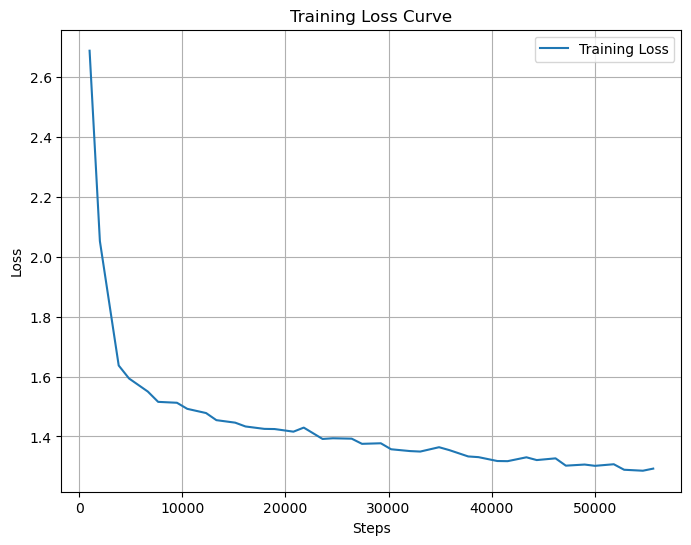

In [29]:
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

# Define the path to the TensorBoard log directory
log_dir = "runs/summary/MDE_Net_20241219_175443"  

# Initialize TensorBoard event accumulator
event_acc = EventAccumulator(log_dir)
event_acc.Reload()  # Load the TensorBoard log data

# List all available tags in the logs
tags = event_acc.Tags()["scalars"]
print("Available Tags:", tags)

# Fetch scalar data for a specific tag
scalar_data = event_acc.Scalars("Loss/train")  # Update to the correct tag

# Extract steps and values
steps = [x.step for x in scalar_data]
values = [x.value for x in scalar_data]

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(steps, values, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.015686285257339505..1.0000000236034394].


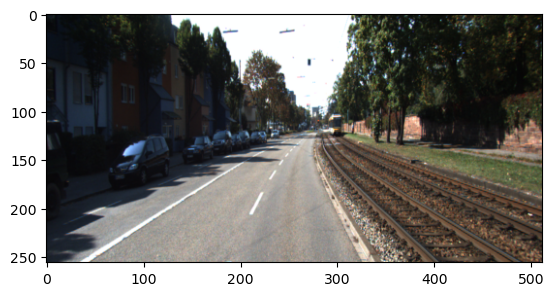

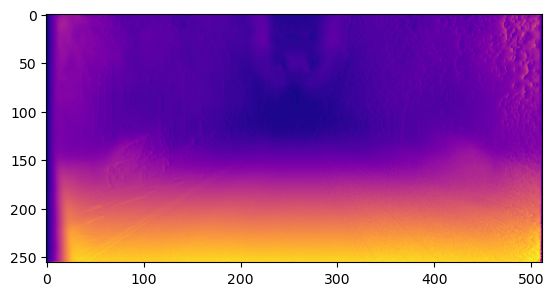

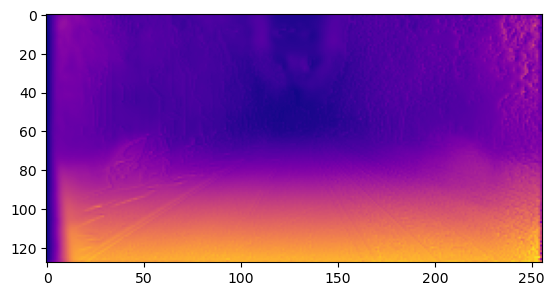

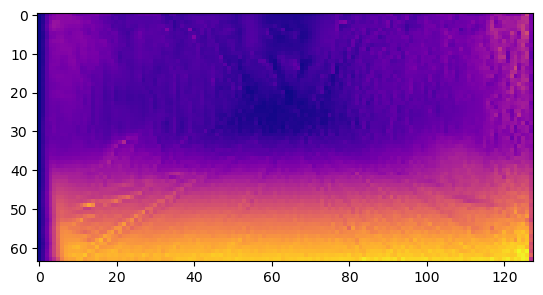

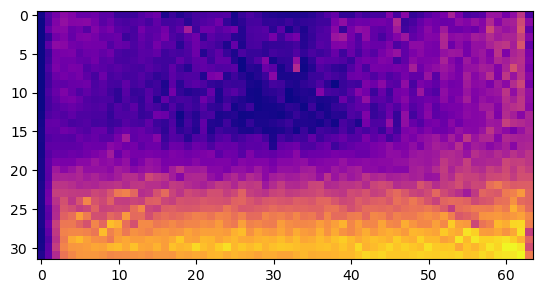

In [21]:
from matplotlib import pyplot as plt

# plot sanity check image before running network
for i, tdata in enumerate(sanity_loader):
    left_img, _ = tdata
    unnormalized_img = left_img[0].permute(1, 2, 0).cpu().numpy()
    unnormalized_img = unnormalized_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    plt.imshow(unnormalized_img)
    plt.show()
    break

# run network on single instance from test_loader
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

from mylibs.utils import post_process_disparity
with torch.no_grad():
    for i, tdata in enumerate(sanity_loader):
        left_img, right_img = tdata
        left_img, right_img = left_img.to(device), right_img.to(device)

        dispArr = model(left_img)
        for disp in dispArr:
            depthMap = post_process_disparity(disp[0].cpu().numpy())
            plt.imshow(depthMap, cmap='plasma')
            plt.show()
        break


Test image: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011764707922935491..1.0000000236034394].


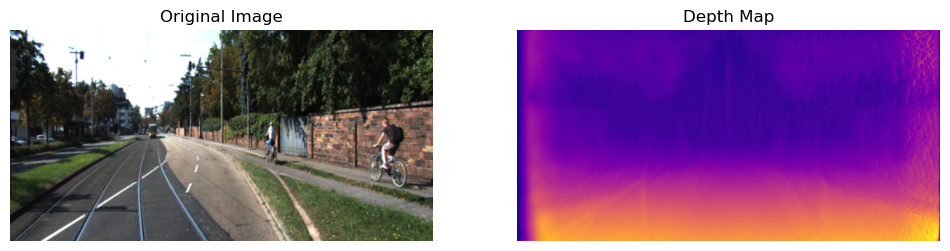

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011764687061309786..1.0000000236034394].


Test image: 1


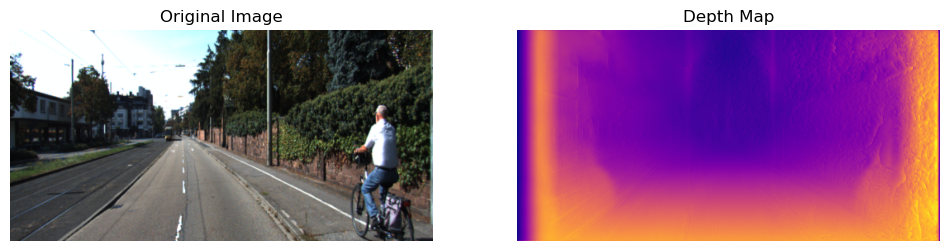

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.003921580076217679..1.0000000236034394].


Test image: 2


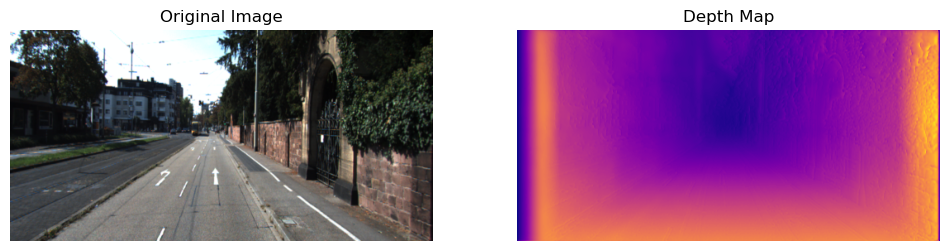

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011764687061309786..1.0000000236034394].


Test image: 3


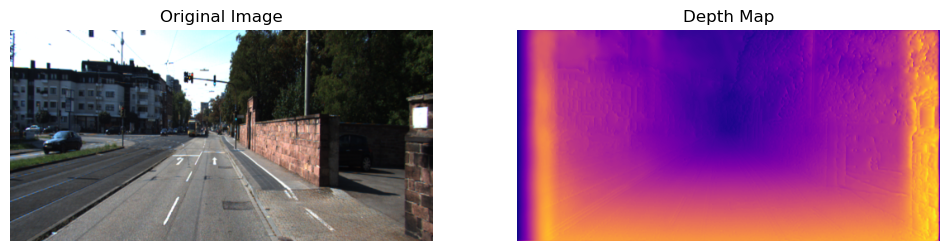

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.015686285257339505..1.0000000236034394].


Test image: 4


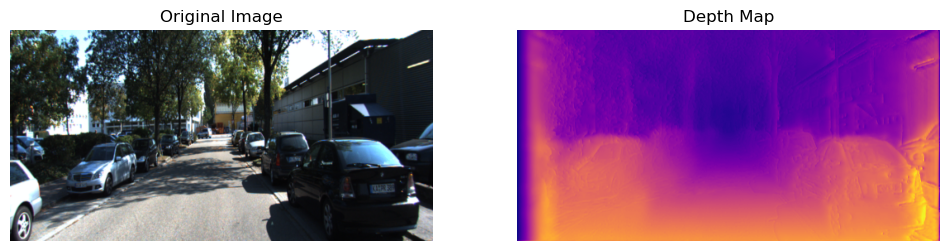

Test image: 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019607832670211767..1.0000000236034394].


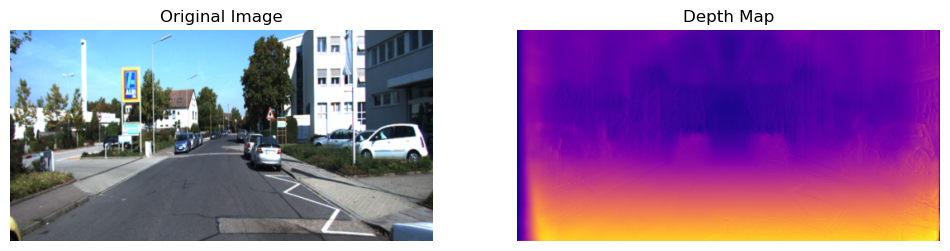

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843130588531533..1.0000000236034394].


Test image: 6


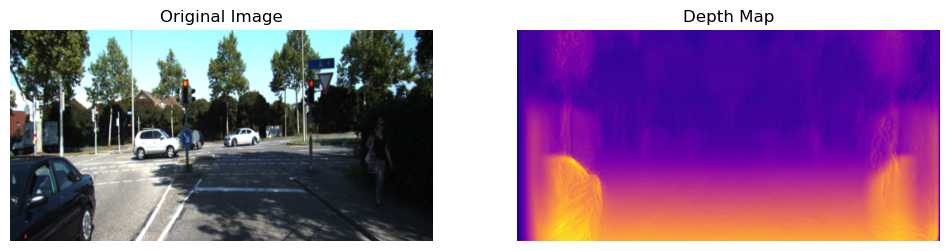

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.015686285257339505..1.0000000236034394].


Test image: 7


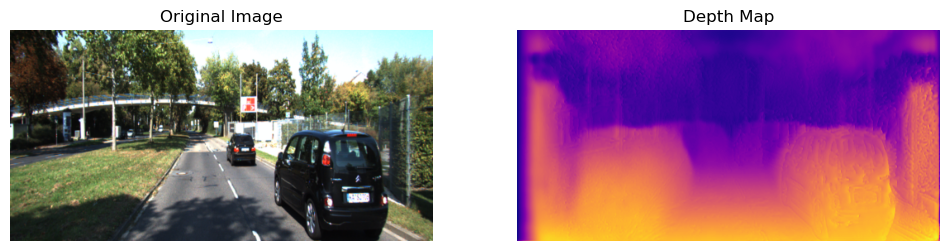

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843130588531533..1.0000000236034394].


Test image: 8


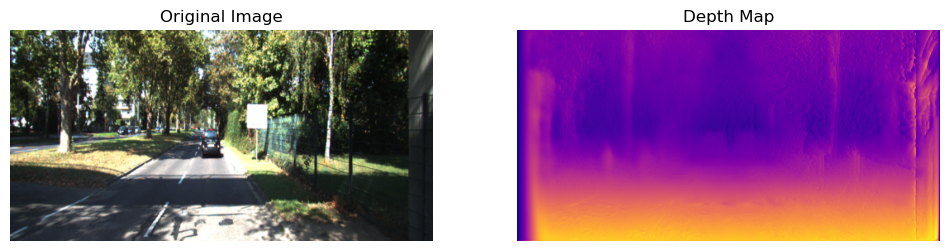

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.003921541452407806..1.0000000236034394].


Test image: 9


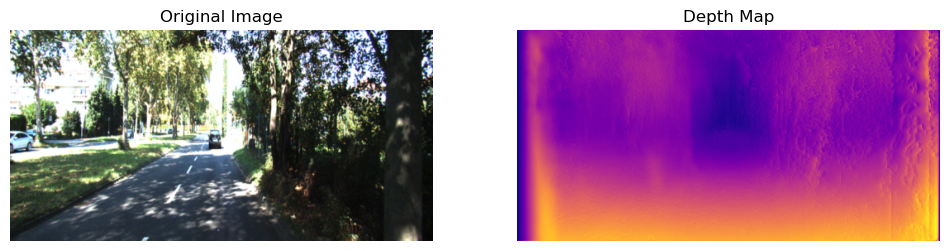

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843130588531533..1.0000000236034394].


Test image: 10


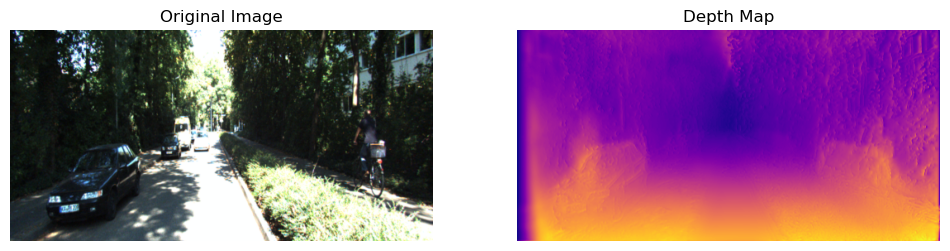

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011764707922935491..1.0000000236034394].


Test image: 11


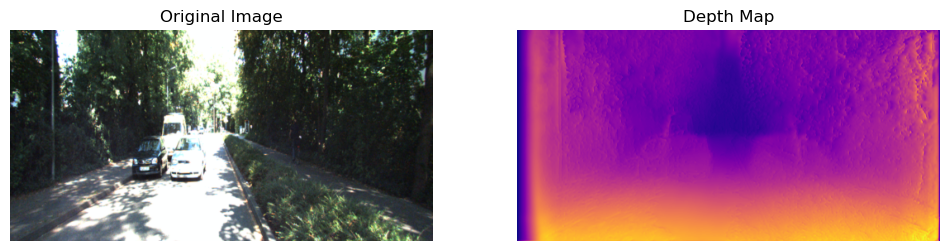

In [22]:
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

from mylibs.utils import post_process_disparity
with torch.no_grad():
    for i, tdata in enumerate(test_loader):
        left_img, right_img = tdata
        left_img, right_img = left_img.to(device), right_img.to(device)

        dispArr = model(left_img)
        for disp in dispArr:
            print("Test image:", i)
            image = left_img[0].cpu().permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            depthMap = post_process_disparity(disp[0].cpu().numpy())
            
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].imshow(image)
            ax[0].set_title("Original Image")
            ax[0].axis("off")

            ax[1].imshow(depthMap, cmap='plasma')
            ax[1].set_title("Depth Map")
            ax[1].axis("off")
            plt.show()
            break

        if i > 10:
            break

## Conclusions

### Summary of Results
### Training/Validation Loss
The model training/validation loss seems to consistenly decrease over the epochs, with a significant decrease over the first epochs. From a visual standpoint, the model seems to accurately estimate depth for images with cars inside (Test image 4, for example). Though the clarity of the images can be improved, perhaps by training for more epochs (Godard trains for 30 before adjusting the learning rate (LR), whereas this implementaion trains for 20 epochs without LR changes). 


### Future Improvements
#### Larger Dataset and Handling:
Increasing the size and diversity of the dataset is a straightforward way to improve the model's performance, since it is a better coverage of the real-world domain, enabling the model to make more accurate assumptions and generalizations. As Godard et al. demonstrated, combining datasets such as KITTI and Cityscapes significantly improves loss metrics and generalization. Adding supplementary datasets like Cityscapes could be an immediate extension to the current implementation. Additionally, utilizing techniques such as k-means cross-validation could help improve the model's robustness by ensuring it performs well across diverse subsets of the data (though this would make the model incomparable to those obeying the eigen split).

#### Semantic Guidance for MDE:

An interesting extension to the current work would be to incorporate semantically guided MDE, where a semantic segmentation network is used to guide the depth estimation process. Such a network can provide high-level contextual information about the scene, such as object boundaries and classifications. This additional guidance can help the model estimate depth more accurately, especially for objects with complex geometries or textures that are otherwise challenging to resolve with geometric cues alone; ultimately leading to a more robust and precise model.

#### Citations
- Yuri Boykov, Lecture 12: Depth from Single View

- https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8100182
- https://www.cs.utoronto.ca/~bonner/courses/2020s/csc2547/papers/discriminative/image-transformation/depth-prediction,-eigen,-nips-2014.pdf
- https://www.researchgate.net/publication/357675635_Semantically_guided_self-supervised_monocular_depth_estimation

- https://www.youtube.com/watch?v=sz30TDttIBA